In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, r2_score, precision_recall_fscore_support
import common.metrics as met
import common.plots as plo
from common.h5py_loading import load_target_map, load_dataset
from common.h5py_data_loader import H5pyDataLoader
from common.prediction_analysis import df_from_chembl_export, intersect_truth_prediction
from lasagne_nn.run_nn import get_predictions_of_knowns, get_network_from_weights
from lasagne_nn.output_loader import df_from_prediction_path

import matplotlib.colors as mc
import colorsys

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File 

In [2]:
# data handling

def get_env_var(handle):
    ''' Get an environment variable given the handle for the bash variable'''
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")

def get_preds(dset, fold):
    indir="{}/output/20180815_Paper_Retrains/predictions/scrambled_idx_no_SMA".format(get_env_var("HOME_SAVE_BASE"))
    knowns_file = "{}/scrambled_idx_no_SMA_1.0_{}_fold_{}_regression_knowns.npz".format(indir, dset, fold)
    preds_file = "{}/scrambled_idx_no_SMA_1.0_{}_fold_{}_regression_preds.npz".format(indir, dset, fold)

    pred_npz = np.load(preds_file)
    known_npz = np.load(knowns_file)
    
    prediction = pred_npz["arr_0"]
    truth = known_npz["arr_0"]
    
    return prediction, truth

def predictions_knowns_from_trained_network_and_data(hdf5_file, weights_filename, build_nn_script,
                                                     test_indices_file=None,
                                                     npKi=False, multitask=False,
                                                     network_target_map_file=None,
                                                     dataset_target_map_file=None):
    network = get_network_from_weights(weights_filename, build_nn=build_nn_script)
    network_target_map = load_target_map(network_target_map_file) if network_target_map_file else None
    data_loader = H5pyDataLoader(hdf5_file=hdf5_file, test_indices_file=test_indices_file,
                                 npKi=npKi, multitask=multitask,
                                 target_map_file=dataset_target_map_file,
                                 train_percentage=None)
    data_loader.load_training_data()
    predictions, knowns = get_predictions_of_knowns(data_loader=data_loader,
                                                    weights_filename=weights_filename,
                                                    indices=data_loader.train_indices,
                                                    network=network,
                                                    network_target_map=network_target_map)
    return predictions, knowns


In [3]:
# plotting 
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Credit: Ian Hincks from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.colorConverter.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def set_nice_spines(ax=None, sides=('left', 'bottom'), color="black", linewidth=1.5):
    if not ax:
        ax = plt.gca()
    for side in sides:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(color)
        ax.spines[side].set_linewidth(linewidth)
    ax.tick_params(axis='both', labeltop='off', labelright='off')
    x_labels = map(str, ax.get_xticks().tolist())
    x_labels[:-1] = ['']*(len(x_labels) - 1)
    ax.set_xticklabels(x_labels, size=10)
    y_labels = map(str, ax.get_yticks().tolist())
    y_labels[1:-1] = ['']*(len(y_labels) - 2)
    ax.set_yticklabels(y_labels, size=10)
    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -18
    

In [4]:
def plot_roc_curves(train_dir_fmter, save_name=None, thresh=6.0, figsize = (10, 10)):
    reload(met)
    reload(plo)
    plt.clf()
    current_palette = sns.color_palette("deep")
    sns.set_palette(current_palette)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_context("paper")
    sns.set(font_scale=2)
    
    labels = []
    aucs = []
    
    colors = sns.color_palette("deep", 4)

    # TRAIN
    color = colors[0]
    first = True
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds("train", fold)
        known_mask = ~np.isnan(truth)
        truth = truth[known_mask]
        prediction = prediction[known_mask]
        
        auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                                  x_y_type='tpr-fpr', show_legend=False, 
                                  **{"color":lighten_color(color, amount=0.4)})
        if first:
            tr_preds = prediction
            tr_truths = truth
            first = False
        else: 
            tr_preds = np.hstack([tr_preds, prediction])
            tr_truths = np.hstack([tr_truths, truth])
        

    # TEST
    color = colors[1]
    first = True
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds("test", fold)
        known_mask = ~np.isnan(truth)
        truth = truth[known_mask]
        prediction = prediction[known_mask]
        auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                                  x_y_type='tpr-fpr', show_legend=False, 
                                  **{"color":lighten_color(color, amount=0.4)})
        if first:
            test_preds = prediction
            test_truths = truth
            first = False
        else: 
            test_preds = np.hstack([test_preds, prediction])
            test_truths = np.hstack([test_truths, truth])
    

    
    
    
    # DM
    dm_exprt = '/srv/home/nmew/data/drugmatrix/drugmatrix_full_chembl20_cutoff800.csv'
    
    color = colors[2]
    first = True
    for fold in np.arange(0,5,1):
        train_dir = train_dir_fmter.format(fold)
        dm_prediction = os.path.join(train_dir, 'drug-matrix', 'model_at_epoch_200_prediction.csv')
        tdf, pdf = intersect_truth_prediction(df_from_chembl_export(dm_exprt, fill_unknowns=False),
                                              df_from_prediction_path(dm_prediction))
        prediction, truth = pdf.values, tdf.values
        auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                                  x_y_type='tpr-fpr', show_legend=False, 
                                  **{"color":lighten_color(color, amount=0.4)})
        if first:
            dm_preds = prediction
            dm_truths = truth
            first = False
        else: 
            dm_preds = np.hstack([dm_preds, prediction])
            dm_truths = np.hstack([dm_truths, truth])
    
    
    # TS
    color = colors[3]
    first = True
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds("timesplit", fold)
        known_mask = ~np.isnan(truth)
        truth = truth[known_mask]
        prediction = prediction[known_mask]
        
        auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                                  x_y_type='tpr-fpr', show_legend=False, 
                                  **{"color":lighten_color(color, amount=0.4)})
        if first:
            ts_preds = prediction
            ts_truths = truth
            first = False
        else: 
            ts_preds = np.hstack([ts_preds, prediction])
            ts_truths = np.hstack([ts_truths, truth])
           
    # Plot averages
    
    auc = plo.plot_binary_auc(tr_preds, tr_truths, threshold=thresh, plot_rand=False,
                              ax=ax, x_y_type='tpr-fpr', show_legend=False, **{"color":colors[0]})
    train_name = "Train Set (auc={:0.3f})".format(auc)
    labels.append((train_name, "-"))
    
    auc = plo.plot_binary_auc(test_preds, test_truths, threshold=thresh, plot_rand=False,
                              ax=ax, x_y_type='tpr-fpr', show_legend=False, **{"color":colors[1]})
    test_name = "Test Set (auc={:0.3f})".format(auc)
    labels.append((test_name, "--"))
    
    auc = plo.plot_binary_auc(dm_preds, dm_truths,  threshold=thresh, plot_rand=False,
                              ax=ax, x_y_type='tpr-fpr', show_legend=False, **{"color":colors[2]})
    aucs.append(auc)
    dm_name = "Drug Matrix (auc={:0.3f})".format(auc)
    labels.append((dm_name, "-."))
    
    auc, rand_auc = plo.plot_binary_auc(ts_preds, ts_truths, threshold=thresh,
                                        ax=ax, x_y_type='tpr-fpr', show_legend=False, 
                                        plot_rand=True, **{"color":colors[3]})
    aucs.append(auc)
    
    ts_name = "Time Split (auc={:0.3f})".format(auc)
    rand_name = "Random (auc={:0.3f})".format(0.5)
    
    labels.append((ts_name, ":"))
    labels.append((rand_name, "--"))
    
    # ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)

    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)

    lines=[]
    for line, (label, style) in zip(ax.lines, labels):
        if label == train_name:
            line.set_color(colors[0])
        if label == test_name:
            line.set_color(colors[1])
        if label == dm_name:
            line.set_color(colors[2])
        if label == ts_name:
            line.set_color(colors[3])
        if label == rand_name:
            line.set_color("grey")
            line.set_linestyle(style)
        line.set_label(label)
        line.set_clip_on(False)
        lines.append(line)
        
    
    lois = [train_name, test_name, dm_name, ts_name, rand_name]
    
    plt.legend(lines, lois, loc="lower right")
    plt.tight_layout()
    plt.title("AUROC Curve Summary")
    
    if save_name:
        plt.savefig(save_name)
        plt.close()
    else: 
        plt.show()
    
    return

In [5]:
save_base = get_env_var("HOME_SAVE_BASE")
train_base = "{}/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA".format(save_base)
train_dir_fmter = "{}/fold_{}/pnr_1.0/".format(train_base, "{}")

new_save_base = get_env_var("HOME")

img_base ="{}/labgits/lab-notebook-caceres.wiki/images".format(new_save_base)
expt_base = "{}/20180815_Paper_Retrains/lr_nesterov_1024_2048_3072/scrambled_idx_no_SMA".format(img_base)
auroc_fmter = "{}/AUROC_thresh_{}_summmary.png".format(expt_base, "{}")
auprc_fmter = "{}/AUPRC_{}_thresh_{}_summary.png".format(expt_base, "{}", "{}")

## plot AUROC summary curve

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


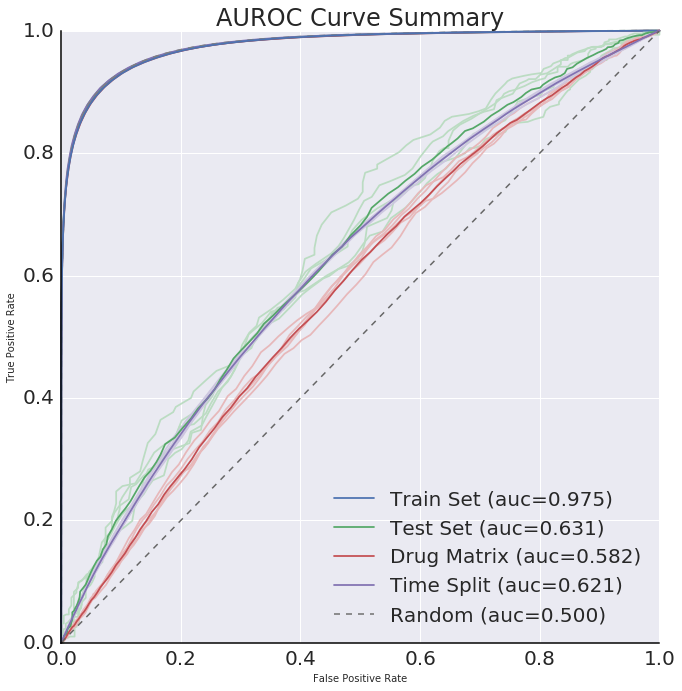

In [12]:
thresh=6.0
figsize=(4,4)
dpi=300
plot_roc_curves(train_dir_fmter, thresh=thresh)

In [82]:
thresh=6.0
figsize=(4,4)
dpi=300
plot_roc_curves(train_dir_fmter, thresh=thresh, save_name=auroc_fmter.format(thresh))

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## plot AUPRC summary curves

In [19]:
def mask_data(prediction, truth):
    known_mask = ~np.isnan(truth)
    truth = truth[known_mask]
    prediction = prediction[known_mask]
    return prediction, truth

In [20]:
def plot_test_train_auprc(save_name=None, thresh=6.0, figsize=(4,4), dpi=300):
    # TEST AND TRAIN TOGETHER At theshold of 6.0# TEST A 
    plt.clf()
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)    
    sns.set_context("paper")
    colors = sns.color_palette("cubehelix", 2)
    # train
    color = colors[0]
    first = True
    
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds("train", fold)
        prediction, truth = mask_data(prediction, truth)
        auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                                   x_y_type='precision-recall', show_legend=False, 
                                  **{"color":lighten_color(color, amount=0.4)})
        if first:
            all_preds = prediction
            all_truths = truth
            first = False
        else: 
            all_preds = np.hstack([all_preds, prediction])
            all_truths = np.hstack([all_truths, truth])
        
        
    tr_auc = plo.plot_binary_auc(all_preds, all_truths, threshold=thresh, 
                                 ax=ax, x_y_type='precision-recall', 
                                 show_legend=False, plot_rand=False, **{"color":color})

    # test
    color = colors[1]
    first = True
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds("test", fold)
        prediction, truth = mask_data(prediction, truth)
        auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                                   x_y_type='precision-recall', show_legend=False, 
                                  **{"color":lighten_color(color, amount=0.4)})
        if first:
            all_preds = prediction
            all_truths = truth
            first = False
        else: 
            all_preds = np.hstack([all_preds, prediction])
            all_truths = np.hstack([all_truths, truth])
        
    auc, rand_auc = plo.plot_binary_auc(all_preds, all_truths, threshold=thresh, 
                                        ax=ax, x_y_type='precision-recall', 
                                        show_legend=False, **{"color":color})

    for side in ['left', 'bottom']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color("black")
        ax.spines[side].set_linewidth(1.5)

    for line, (label, style) in zip(ax.lines, 
                                    [("Train Set (auc = {:0.3f})".format(tr_auc), '-'),
                                     ("Test Set  (auc = {:0.3f})".format(auc), '-'),
                                     ("Random  (auc = {:0.3f})".format(rand_auc), '--')]):
        line.set_label(label)
        line.set_linestyle(style)
        line.set_clip_on(False)

    plt.legend(loc='lower right')
    plt.title("Scrambled index AUPRC Curve for summary at threshold {}".format(thresh))
    
    if save_name:
        plt.savefig(save_name)
        plt.close()
    else: 
        plt.show()
    
    return

def plot_dm_auprc(fold, save_name=None, thresh=6.0, figsize=(6,6), dpi=300):
    
    prediction, truth = get_preds("drugmatrix", fold)

    plt.clf()
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.set_context("paper")
    
    auc, rand_auc = plo.plot_binary_auc(prediction, truth, threshold=6., 
                                        ax=ax, x_y_type='precision-recall', 
                                        show_legend=False)
    
    for side in ['left', 'bottom']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color("black")
        ax.spines[side].set_linewidth(1.5)
        
    for line, (label, style) in zip(ax.lines, [("DM  (auc = {:0.3f})".format(auc), '-'),
                                               ("Base (auc = {:0.3f})".format(rand_auc), '--')]):
        line.set_label(label)
        line.set_linestyle(style)
        line.set_clip_on(False)
        
#     set_nice_spines(ax)
    plt.title("Scrambled index AUPRC Curve for fold {} at threshold {}".format(fold, thresh))
    ax.legend(loc='upper right', borderpad=0., borderaxespad=0.25, prop={'family': 'monospace', 'size': 11})
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name)
        plt.close()
    else: 
        plt.show()
    
    return

def plot_ts_auprc(fold, save_name=None, thresh=6.0, figsize=(4,4), dpi=300):
    
    prediction, truth = get_preds("timesplit", fold)
    known_mask = ~np.isnan(truth)
    truth = truth[known_mask]
    prediction = prediction[known_mask]
    
    plt.clf()
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.set_context("paper")
    
    auc, rand_auc = plo.plot_binary_auc(prediction, truth, threshold=6., 
                                        x_y_type='precision-recall',
                                        ax=ax, show_legend=False)
    
    for side in ['left', 'bottom']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color("black")
        ax.spines[side].set_linewidth(1.5)
        
    
    for line, (label, style) in zip(ax.lines, [("TS  (auc = {:0.3f})".format(auc), '-'),
                                               ("Base (auc = {:0.3f})".format(rand_auc), '--')]):
        line.set_label(label)
        line.set_linestyle(style)
        line.set_clip_on(False)
        
    #set_nice_spines(ax)
    plt.title("Scrambled index AUPRC Curve for fold {} at threshold {}".format(fold, thresh))
    ax.legend(loc='lower right', borderpad=0., borderaxespad=0.25, 
              prop={'family': 'monospace', 'size': 11})
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name)
        plt.close()
    else: 
#         plt.show()
    
        return ax


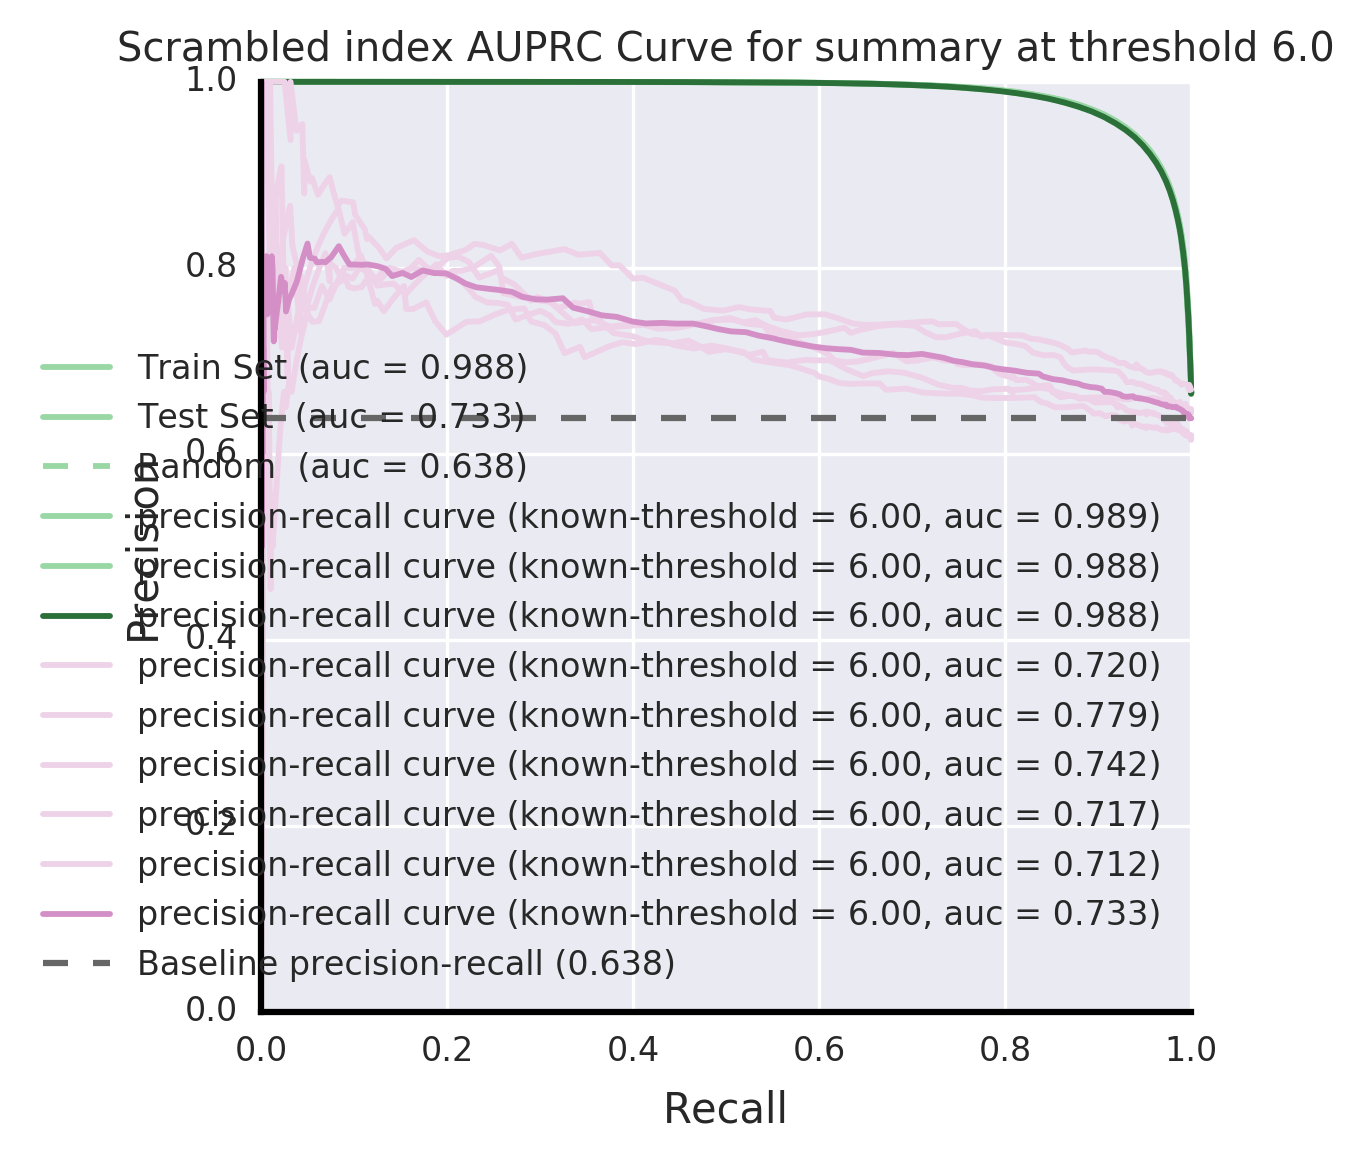

In [21]:
thresh=6.0
figsize=(4,4)
dpi=300
ax = plot_test_train_auprc(thresh=thresh)

KeyboardInterrupt: 

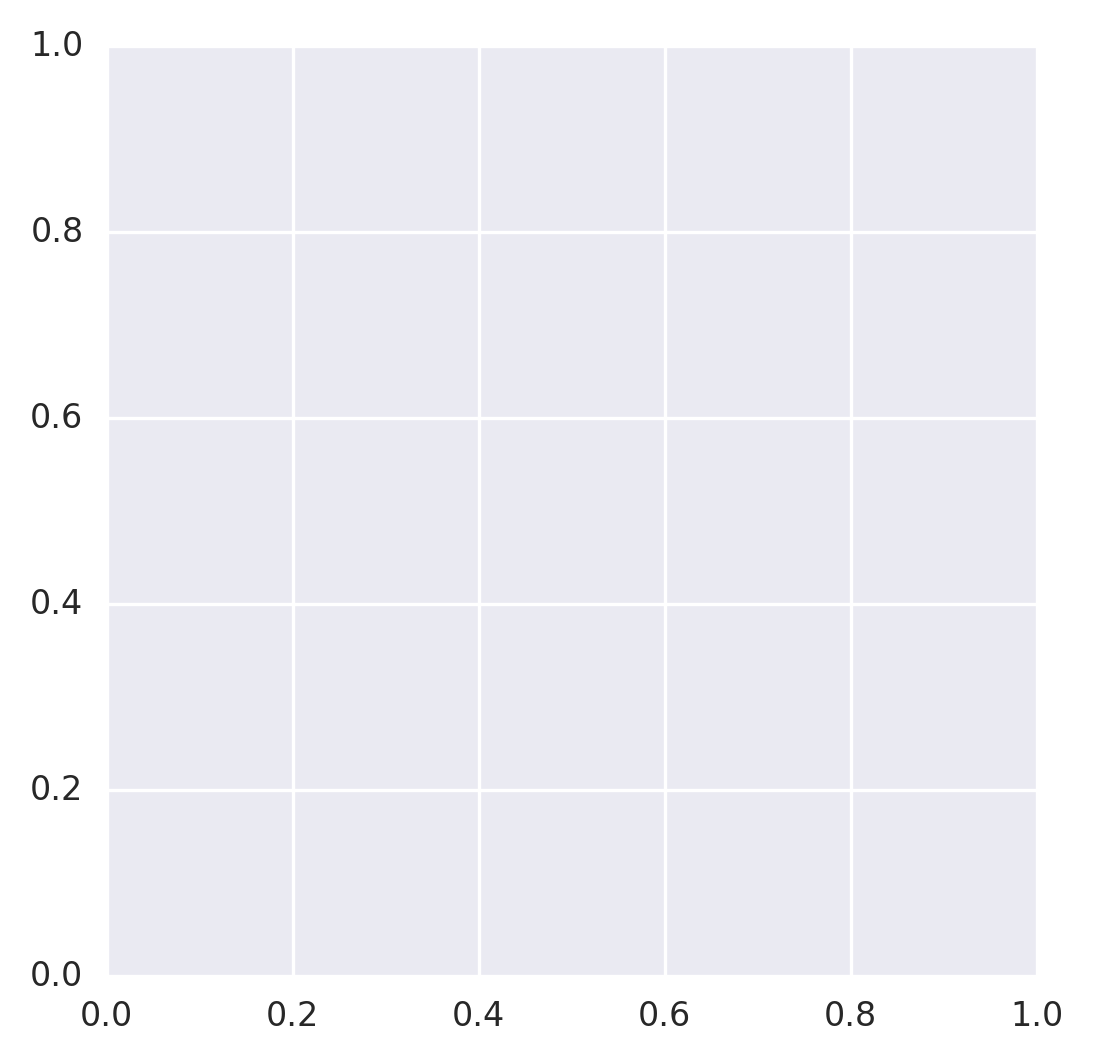

In [40]:
plt.clf()
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)    
sns.set_context("paper")
colors = sns.color_palette("cubehelix", 2)
# train
color = colors[0]
first = True

for fold in np.arange(0,5,1):
    prediction, truth = get_preds("train", fold)
    prediction, truth = mask_data(prediction, truth)
    auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                               x_y_type='precision-recall', show_legend=False, 
                              **{"color":lighten_color(color, amount=0.4)})
    if first:
        all_preds = prediction
        all_truths = truth
        first = False
    else: 
        all_preds = np.hstack([all_preds, prediction])
        all_truths = np.hstack([all_truths, truth])


tr_auc = plo.plot_binary_auc(all_preds, all_truths, threshold=thresh, 
                             ax=ax, x_y_type='precision-recall', 
                             show_legend=False, plot_rand=False, **{"color":color})


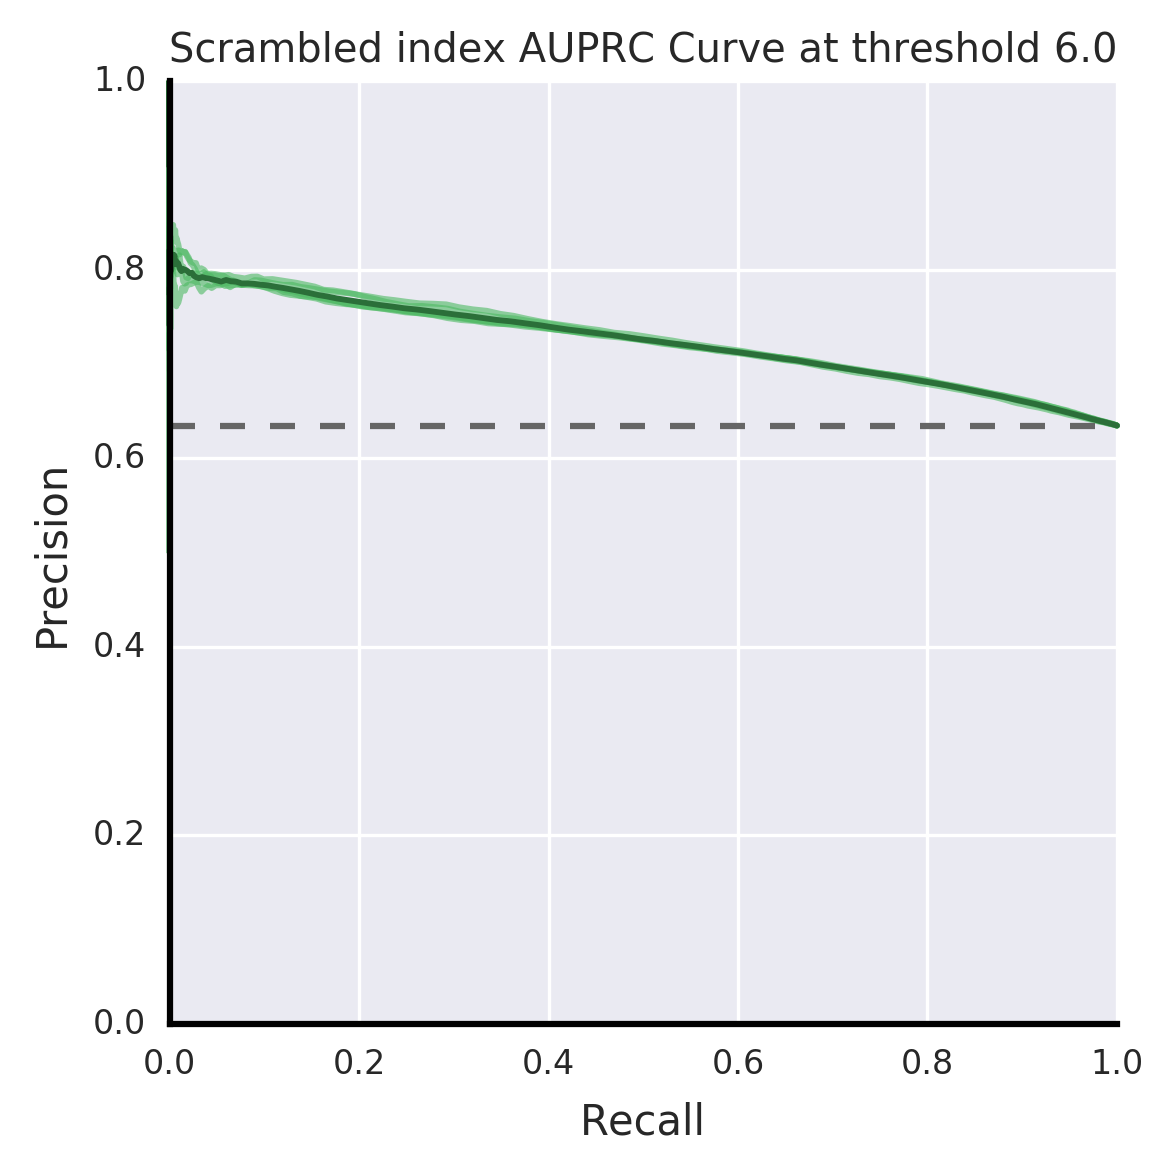

In [53]:
plt.clf()
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)    
sns.set_context("paper")
colors = sns.color_palette("cubehelix", 2)
# train
color = colors[0]
first = True

for fold in np.arange(0,5,1):
    prediction, truth = get_preds("timesplit", fold)
    prediction, truth = mask_data(prediction, truth)
    auc = plo.plot_binary_auc(prediction, truth, threshold=thresh, plot_rand=False,ax=ax, 
                               x_y_type='precision-recall', show_legend=False, 
                              **{"color":lighten_color(color,amount=0.7), "alpha":0.6})
    if first:
        all_preds = prediction
        all_truths = truth
        first = False
    else: 
        all_preds = np.hstack([all_preds, prediction])
        all_truths = np.hstack([all_truths, truth])


auc, rand_auc = plo.plot_binary_auc(all_preds, all_truths, threshold=6., 
                                    x_y_type='precision-recall',
                                    ax=ax, show_legend=False, plot_rand=True,
                                    **{"color":color} )

for side in ['left', 'bottom']:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_color("black")
    ax.spines[side].set_linewidth(1.5)


all_lines = []
lines_of_interest = ["TS  (auc = {:0.3f})".format(auc), "Base (auc = {:0.3f})".format(rand_auc)]
# for line, (label, style) in zip(ax.lines, [("TS  (auc = {:0.3f})".format(auc), '-'),
#                                            ("Base (auc = {:0.3f})".format(rand_auc), '--')]):
#     line.set_label(label)
#     line.set_linestyle(style)
#     line.set_clip_on(False)
#     all_lines.append(label)
    
#set_nice_spines(ax)
plt.title("Scrambled index AUPRC Curve at threshold {}".format(thresh))
ax.legend(all_lines, all_lines[0:2], loc='lower right', borderpad=0., borderaxespad=0.25, 
          prop={'family': 'monospace', 'size': 11})
plt.tight_layout()

# if save_name:
#     plt.savefig(save_name)
#     plt.close()
# else: 
# #         plt.show()
#     pass


In [48]:
for i in ax.lines:
    print i

Line2D(TS  (auc = 0.724))
Line2D(Base (auc = 0.635))
Line2D(precision-recall curve (known-threshold = 6.00, auc = 0.724))
Line2D(precision-recall curve (known-threshold = 6.00, auc = 0.725))
Line2D(precision-recall curve (known-threshold = 6.00, auc = 0.723))
Line2D(precision-recall curve (known-threshold = 6.00, auc = 0.724))
Line2D(Baseline precision-recall (0.635))
